In [1]:
import os

USE_LOCAL_RUNTIME = True

if USE_LOCAL_RUNTIME:
    # '/home/tom/Workspace/hypeminer/misc/optimisation'
    os.chdir('C:/Users/Agando/Workspace/hypeminer/misc/optimisation') 
else:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/hypeminer/training-data/optimisation')

In [2]:
import json
import pandas as pd
from datetime import datetime

symbol = 'BNBUSDT'
start = '20200101000000'
freq = 5
days = 365
strategy = 'MACDDPnL'

# ---------------------------------------------------------

def to_datetime(timestamp):
    return datetime(
      int(timestamp[0:4]), int(timestamp[4:6]), int(timestamp[6:8]), 
      int(timestamp[8:10]), int(timestamp[10:12]), int(timestamp[12:14])
  )

def get_value(v):
    try:
        return float(v['value'])
    except:
        return float(v['value'][0][1])

def load_file(file):
    df = pd.DataFrame()
    with open(file) as f:
        data = json.load(f)
    df['ds'] = [datetime.strptime(v['timestamp'], '%Y-%m-%d %H:%M:%S') for v in data]
    df['open'] = [get_value(v) for v in data]
    return df

strategies = {
    'MACDDPnL': "MACD Diff Peak&Limit",
}

run_id = f"{symbol}-{start}-{freq}-{days}-{strategy}"
run_title = f"{symbol} - {strategies[strategy]} at {days} days from " \
            f"{to_datetime(start).strftime('%Y-%m-%d')} every {freq} minutes"
file = f"{symbol}-{start}-{freq}-{days}.json"

df = load_file(file)
df

,ds,open
0,2020-01-01 00:00:00,13.7159
1,2020-01-01 00:05:00,13.7010
2,2020-01-01 00:10:00,13.7125
3,2020-01-01 00:15:00,13.7051
4,2020-01-01 00:20:00,13.7024
...,...,...
105116,2020-12-30 23:40:00,38.0611
105117,2020-12-30 23:45:00,38.2087
105118,2020-12-30 23:50:00,38.1183
105119,2020-12-30 23:55:00,38.0900


In [3]:
def ema(data, n):
    alpha = 2 / (1 + n)
    return data.ewm(alpha=alpha, adjust=False).mean()

df['ema12'] = ema(df['open'], 12)
df['ema26'] = ema(df['open'], 26)
df['macd'] = df['ema12'] - df['ema26']
df['signal'] = ema(df['macd'], 9)
df['macddiff'] = df['macd'] - df['signal']

df

,ds,open,ema12,ema26,macd,signal,macddiff
0,2020-01-01 00:00:00,13.7159,13.715900,13.715900,0.000000,0.000000,0.000000
1,2020-01-01 00:05:00,13.7010,13.713608,13.714796,-0.001189,-0.000238,-0.000951
2,2020-01-01 00:10:00,13.7125,13.713437,13.714626,-0.001189,-0.000428,-0.000761
3,2020-01-01 00:15:00,13.7051,13.712155,13.713921,-0.001766,-0.000696,-0.001070
4,2020-01-01 00:20:00,13.7024,13.710654,13.713067,-0.002413,-0.001039,-0.001374
...,...,...,...,...,...,...,...
105116,2020-12-30 23:40:00,38.0611,37.865194,37.818075,0.047120,0.028692,0.018427
105117,2020-12-30 23:45:00,38.2087,37.918041,37.847010,0.071032,0.037160,0.033871
105118,2020-12-30 23:50:00,38.1183,37.948850,37.867105,0.081745,0.046077,0.035668
105119,2020-12-30 23:55:00,38.0900,37.970566,37.883616,0.086950,0.054252,0.032698


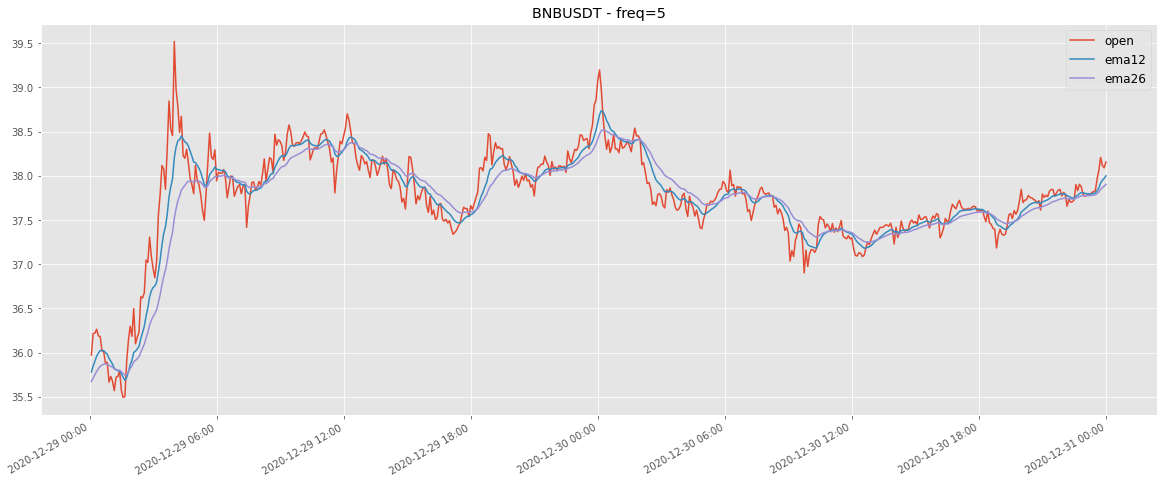

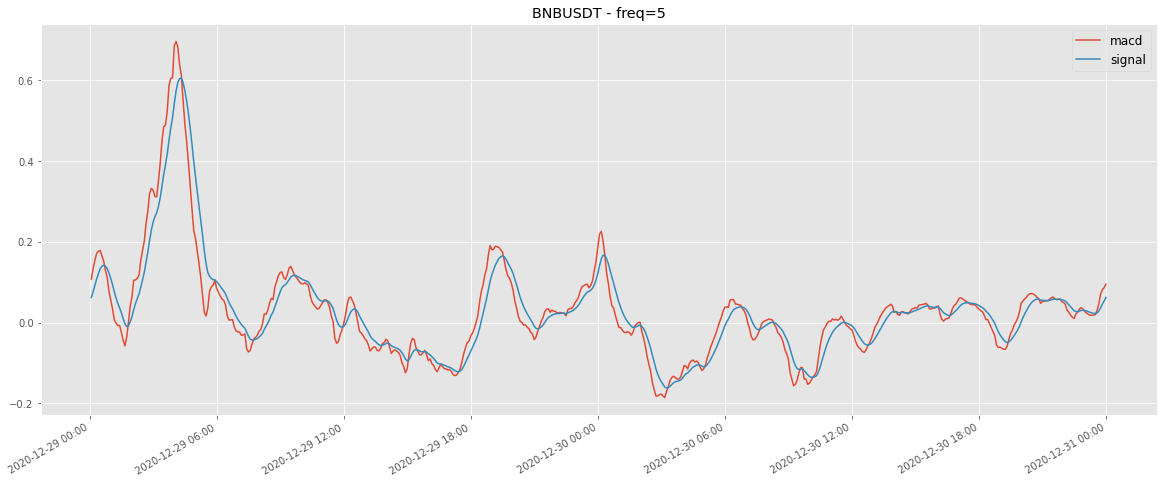

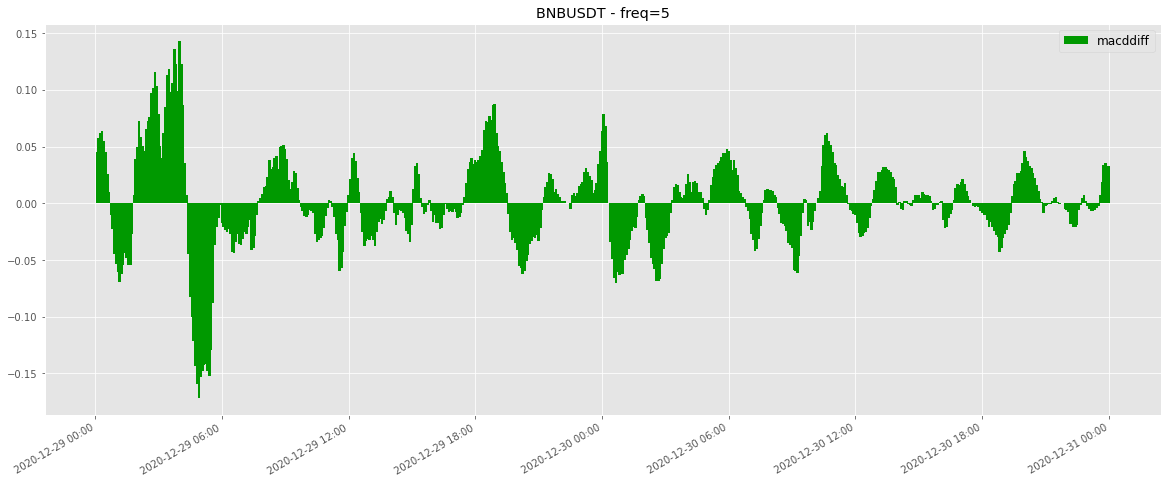

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('ggplot')

def plot(typ, dfs, cols, title=None, baseline=None):
    plt.rcParams["figure.figsize"] = (20, 8)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    for col in cols:
        if typ == 'line':
            plt.plot(dfs['ds'], dfs[col], label=col)
        elif typ == 'bars':
            plt.bar(dfs['ds'], dfs[col], color='#009900', label=col, width=.005)
    if baseline:
        plt.axhline(y=baseline, color='b', linestyle='-', label='buy and hold')
    plt.legend(loc="best", prop={'size': 12})
    if not title:
        title = f"{symbol} - freq={freq}"
    plt.title(title)
    plt.gcf().autofmt_xdate()
    plt.show()

samples = int(2 * 24 * 60 / 5)
dfs = df.iloc[-samples:]

plot('line', dfs, ['open', 'ema12', 'ema26'])
plot('line', dfs, ['macd', 'signal'])
plot('bars', dfs, ['macddiff'])

In [5]:
df['prev_open'] = df['open'].shift(1)

df['is_negative'] = df['macddiff'] < 0
df['macddiff2'] = df['macddiff'].diff()
df['is_upward'] = df['macddiff'].diff() > 0

df['suggest'] = 'IDLE'
df.loc[df['is_negative'] & df['is_upward'], 'suggest'] = 'BUY'

df.iloc[:30]

,ds,open,ema12,ema26,macd,signal,macddiff,prev_open,is_negative,macddiff2,is_upward,suggest
0,2020-01-01 00:00:00,13.7159,13.715900,13.715900,0.000000,0.000000,0.000000,NaN,False,NaN,False,IDLE
1,2020-01-01 00:05:00,13.7010,13.713608,13.714796,-0.001189,-0.000238,-0.000951,13.7159,True,-0.000951,False,IDLE
2,2020-01-01 00:10:00,13.7125,13.713437,13.714626,-0.001189,-0.000428,-0.000761,13.7010,True,0.000190,True,BUY
3,2020-01-01 00:15:00,13.7051,13.712155,13.713921,-0.001766,-0.000696,-0.001070,13.7125,True,-0.000309,False,IDLE
4,2020-01-01 00:20:00,13.7024,13.710654,13.713067,-0.002413,-0.001039,-0.001374,13.7051,True,-0.000304,False,IDLE
5,2020-01-01 00:25:00,13.7023,13.709369,13.712270,-0.002901,-0.001411,-0.001489,13.7024,True,-0.000115,False,IDLE
6,2020-01-01 00:30:00,13.7038,13.708512,13.711642,-0.003130,-0.001755,-0.001375,13.7023,True,0.000114,True,BUY
7,2020-01-01 00:35:00,13.7042,13.707849,13.711091,-0.003242,-0.002053,-0.001190,13.7038,True,0.000185,True,BUY
8,2020-01-01 00:40:00,13.7002,13.706672,13.710284,-0.003612,-0.002365,-0.001248,13.7042,True,-0.000058,False,IDLE
9,2020-01-01 00:45:00,13.7043,13.706307,13.709841,-0.003534,-0.002598,-0.000936,13.7002,True,0.000312,True,BUY


,ds,open,ema12,ema26,macd,signal,macddiff,prev_open,is_negative,macddiff2,is_upward,suggest,limit,stop,assets,action
0,2020-01-01 00:00:00,13.7159,13.715900,13.715900,0.000000,0.000000,0.000000,NaN,False,NaN,False,IDLE,0.000000,0.000000,1.000000,----
1,2020-01-01 00:05:00,13.7010,13.713608,13.714796,-0.001189,-0.000238,-0.000951,13.7159,True,-0.000951,False,IDLE,0.000000,0.000000,1.000000,----
2,2020-01-01 00:10:00,13.7125,13.713437,13.714626,-0.001189,-0.000428,-0.000761,13.7010,True,0.000190,True,BUY,14.123875,12.478375,1.000000,BUY
3,2020-01-01 00:15:00,13.7051,13.712155,13.713921,-0.001766,-0.000696,-0.001070,13.7125,True,-0.000309,False,IDLE,0.000000,0.000000,0.999460,----
4,2020-01-01 00:20:00,13.7024,13.710654,13.713067,-0.002413,-0.001039,-0.001374,13.7051,True,-0.000304,False,IDLE,0.000000,0.000000,0.999263,----
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105116,2020-12-30 23:40:00,38.0611,37.865194,37.818075,0.047120,0.028692,0.018427,37.9634,False,0.011570,True,IDLE,0.000000,0.000000,7.497207,----
105117,2020-12-30 23:45:00,38.2087,37.918041,37.847010,0.071032,0.037160,0.033871,38.0611,False,0.015444,True,IDLE,0.000000,0.000000,7.526281,----
105118,2020-12-30 23:50:00,38.1183,37.948850,37.867105,0.081745,0.046077,0.035668,38.2087,False,0.001796,True,IDLE,0.000000,0.000000,7.508474,----
105119,2020-12-30 23:55:00,38.0900,37.970566,37.883616,0.086950,0.054252,0.032698,38.1183,False,-0.002970,False,IDLE,0.000000,0.000000,7.502900,----


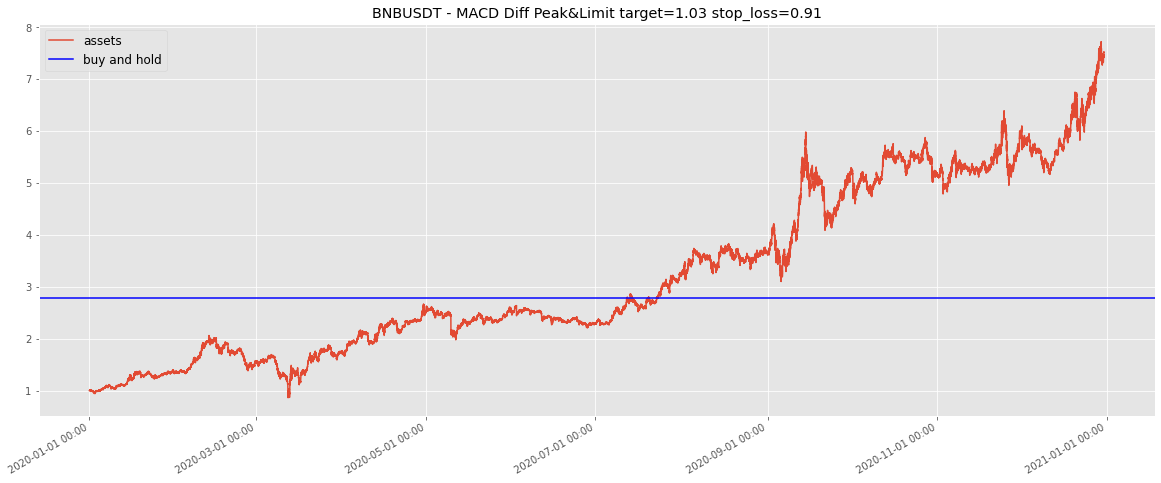

(7.515860966013719, 2.781866301154135)

In [6]:
from IPython.display import display

def compute_macd_diff_peak_and_limit(target, stop_loss, verbose=False, plot_chart=False):

    df['limit'] = 0
    df.loc[df['suggest'] == 'BUY', 'limit'] = df['open'] * target

    df['stop'] = 0
    df.loc[df['suggest'] == 'BUY', 'stop'] = df['open'] * stop_loss

    s = 'OUT' # IN=invested, OUT=liquidated
    assets = 1
    limit = None
    stop = None

    assets_values = []
    actions = []
    for index, row in df.iterrows():
        if s == 'IN': # this depends on the previous state
            assets = assets / row['prev_open'] * row['open']
        if s == 'OUT' and row['suggest'] == 'BUY':
            s = 'IN'
            limit = row['limit']
            stop = row['stop']
            actions.append('BUY')
        elif s == 'IN' and (row['open'] >= limit or row['open'] <= stop):
            s = 'OUT'
            limit = None
            stop = None
            actions.append('SELL')
        else:
            actions.append('----')
        assets_values.append(assets)

    df['assets'] = assets_values
    df['action'] = actions
    bnh = df['open'].iloc[-1] / df['open'].iloc[0]
    
    if verbose:
        display(df)
    
    if plot_chart:
        plot('line', df, ['assets'], title=f"{symbol} - {strategies[strategy]} target={target} stop_loss={stop_loss}",
             baseline=bnh)
    
    return assets, bnh

compute_macd_diff_peak_and_limit(1.03, 0.91, verbose=True, plot_chart=True)

In [7]:
import numpy as np

xs = np.arange(101, 121, 1) / 100
ys = np.flip(np.arange(80, 100, 1)) / 100

tsv_file = f"{run_id}.tsv"

if not os.path.isfile(tsv_file):
    heat = pd.DataFrame()
    targets, stop_losses, baselines, stakes = [], [], [], []
    for target in xs:
        for stop_loss in ys:
            stake, baseline = compute_macd_diff_peak_and_limit(target, stop_loss)
            print("\t".join(["{:.2f}".format(x) for x in [target, stop_loss, baseline, stake]]).expandtabs(8))
            targets.append(target)
            stop_losses.append(stop_loss)
            baselines.append(baseline)
            stakes.append(stake)
    heat['target'] = targets
    heat['stop_loss'] = stop_losses
    heat['baseline'] = baselines
    heat['stake'] = stakes
    heat.to_csv(tsv_file, sep='\t')
else:
    heat = pd.read_csv(tsv_file, sep='\t')

heat

,target,stop_loss,bnh,assets
0,1.01,0.99,2.78,1.52
1,1.01,0.98,2.78,4.59
2,1.01,0.97,2.78,3.48
3,1.01,0.96,2.78,5.88
4,1.01,0.95,2.78,5.89
...,...,...,...,...
395,1.20,0.84,2.78,4.16
396,1.20,0.83,2.78,4.02
397,1.20,0.82,2.78,3.79
398,1.20,0.81,2.78,3.61


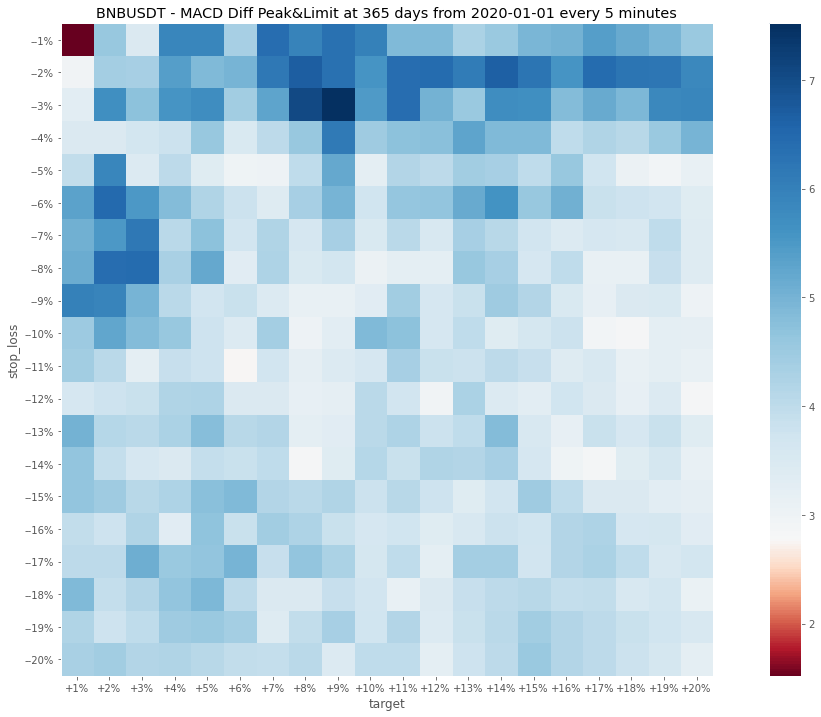

In [8]:
def build_heatmap(heat, file_id):
    info = file_id.split('-')

    X, _ = np.meshgrid(xs, ys)
    Z = np.array(heat['assets']).reshape(X.shape)
    bnh = heat['bnh'].iloc[-1]

    import matplotlib.colors as colors
    class MidpointNormalize(colors.Normalize):
        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
            self.midpoint = midpoint
            colors.Normalize.__init__(self, vmin, vmax, clip)
        def __call__(self, value, clip=None):
            x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
            return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

    # heatmap
    plt.rcParams["figure.figsize"] = (20, 12)
    plt.xticks(range(len(xs)), [f"+{(x-1)*100:.0f}%" for x in xs])
    plt.yticks(range(len(ys)), [f"-{(1-y)*100:.0f}%" for y in xs])
    plt.grid(False)
    plt.title(run_title)
    plt.xlabel('target')
    plt.ylabel('stop_loss')
    heat = plt.imshow(Z, cmap='RdBu', interpolation='nearest', norm=MidpointNormalize(midpoint=bnh))
    plt.colorbar(heat)
    if not os.path.exists(f"plots/{info[4]}"):
        os.makedirs(f"plots/{info[4]}")
    plt.savefig(f"plots/{info[4]}/{file_id}.png")
    plt.show()

build_heatmap(heat, run_id)